ELEC-E5550 - Statistical Natural Language Processing
# SET 3: Vector spaces and Information retrieval

# Released: 06.02.2020
# Deadline: 12.02.2020 at noon

In [13]:
# deadline is Feb 19th at noon

After completing this assignment, you will understand how to construct different document vector spaces, how to find similar documents, and how to evaluate the results of information retrieval systems.

KEYWORDS:
* text normalization
* vector space models
* count-based methods
* sparse vectors
* dense vectors
* PPMI
* tf-idf
* truncated SVD
* cosine similarity
* IR quality

### Data
We're going to use song lyrics.

For training:

* Pulp: Common people
* Pulp: His'n'Hers
* Kanye West: Ye
* Kanye West: 808s & Heartbreak

For testing:

* Pulp: This Is Hardcore
* Kanye West: My Beautiful Dark Twisted Fantasy

In this assignment, we're going to represent documents as points in some high-dimensional vector space. We will try to model their semantics so that similar documents would be close in that space. We're going to work with the song lyrics of two artists. Hopefully, your models will be able to tell the artists apart.

A document will be represented as a vector of values related to word frequencies in this document. The simple intuition behind the method is that word frequencies in a document capture what a corresponding document is about, its meaning. This approach is count-based. Vector spaces are typically constructed from some kind of co-occurrence matrix. We will be using a term-document matrix in this assignment.

In general, the creation of count-based vector models consists of three steps:
1. Linguistic processing of text.
2. Frequency matrix building.
3. Mathematical processing of the matrix elements.

In [3]:
# TF = term frequency
# IDF = inverse document frequency
# PPMI = 

## TASK 1
## Prepare the text 
### Tokenize and normalize
## 1.1

As you already know, we always start by preparing the text to fit our needs. The first step of our process will be **tokenization** (as usual). The second step will be **normalization**. Normalization helps to reduce superficially different strings to one spelling. For example, strings that differ in their capitalization: "Run" and "run", or the strings that differ in their grammatical form: "cat" and "cats". these different strings of characters often convey essentially identical meanings, so it makes sense to unify them into one string in order to get the full distributional statistic. The most common types of normalization for document representations are **lowercasing** and **stemming**.

Stemmers remove morphological affixes from words, leaving only the word stem. For example, words "jumping", “jumped”, and “jumper” will be reduced to the stem "jump". Stemming is just an approximation of a proper morphological analysis and uses a set of rules of thumb. Stemming works well for languages like English, but might not be optimal for morphologically-rich languages like Finnish.

In this assignment, we're going to use Porter’s stemmer. You can look at the algorithm here: https://tartarus.org/martin/PorterStemmer/def.txt

Create a function in a cell below. It should take the name of the text document, read it, tokenize it, and then stem and lowercase the tokens.

In [4]:
import nltk
nltk.download('punkt')
from nltk import word_tokenize, PorterStemmer


def tokenize_and_normalize(file_name):
    """
    this function takes in a path to a song, reads the song file,
    tokenizes it into words, then stems and lowercases these words.
    
    INPUT:
    file_name - a path to a file as a string
    OUTPUT:
    normalized_song - a song represented as a list of stems.
    """
    
    ps = PorterStemmer()
    
    # YOUR CODE HERE
    # import file
    tokens = []
    stems = []
    text = open(file_name).read()
    tokens = word_tokenize(text)
    
    for word in tokens:
        stems.append(ps.stem(word))
        
    normalized_song = [word.lower() for word in stems]
            
    return normalized_song

[nltk_data] Downloading package punkt to /home/taifouz1/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [5]:
from numpy.testing import assert_array_equal
from nose.tools import assert_equal


# CHECKING THE GENERAL PROPERTIES OF THE OUTPUT
dummy_song_path = "/coursedata/dummy_song.txt"

# check that the output of the function is a list
assert_equal(type(tokenize_and_normalize(dummy_song_path)), list)
# check that it's a list of strings
assert_equal(type(tokenize_and_normalize(dummy_song_path)[0]), str)
# CHECKING THAT THE FUNCTION IS WORKING AS IT SHOULD
correct_normalized_dummy_song = ['thi','is','my', 'awesom','song','.','i','sing','everywher','i','go','.',
                                 'lalala',',','lalada',',','dalala',',','yep','yep','!',
                                 'ohhhhh','ohhhhhh','yeaaahhhhh']
assert_equal(tokenize_and_normalize(dummy_song_path), correct_normalized_dummy_song)



### Now we can prepare our songs. 

In [6]:
import glob

# collect the paths to albums and songs
# the order of the albums are: different_class, his_n_hers, 808s_and_heartbreak, ye
train_songs = glob.glob('/coursedata/songs_train/*/*')
normalized_songs = [tokenize_and_normalize(song) for song in train_songs]

In [7]:
#print(normalized_songs)

## TASK 2
### create a term-document matrix
## 2.1
Now that our step one (linguistic processing) is complete, we can go on to compute statistics from documents.

We will be using **term-document matrix**. Formally, in a term-document matrix $X$, each column $x_i$ corresponds to a document $D_i$, each row $x_j$ corresponds to a term $T_j$, and an element $x_{ij}$ is the frequency of a term $T_j$ in a document $D_i$.

Write a function that takes in the pre-processed documents, and puts their statistics into a term-document matrix.

In [8]:
import numpy as np
from collections import Counter

def create_term_doc_matrix(songs_normalized):
    """
    this function takes in a list of songs and returns a term-document matrix as a numpy array.
    the rows are word stems, the columns are songs. 
    the rows should be sorted alphabetically.
    INPUT:
    songs_normalized - a list of songs represented as a list of stems (a list of lists)
    OUTPUT:
    matrix - a matrix where columns are songs and rows are stems,
        the cells of the matrix contain stem frequencies in a song,
        the words for rows are sorted alphabetically.
        
    sorted_vocab - a list of all the words used in all songs (the rows of our matrix).
        the words should be strings sorted alphabetically
    """
    
    # YOUR CODE HERE
    #print(songs_normalized)
    sorted_vocab = []

    for line in songs_normalized:
        for word in line:
            if word in sorted_vocab:
                continue
            else:
                sorted_vocab.append(word)
      
    sorted_vocab = np.sort(sorted_vocab)
    #print("SORTED VOCAB==========+")
    #print(sorted_vocab)
    #print(" ==== = === = == = == ======")
    matrix = []

    for stem in sorted_vocab:
        #print("=For stem: ", stem)
        i = 0
        count = 0
        tmp = np.zeros(len(songs_normalized))
        for song in songs_normalized:
            #print("===For song: ", song)
            for word in song:
                if word == stem:
                    #print("=====YES IT IS IN THE SONG")
                    tmp[i] += 1
                else:
                    #print("=====NO IT ISN'T")
                    continue
            i += 1
        matrix.append(tmp)
        
        
                
            
    #print("SHAPE OF MATRIX. ", np.shape(matrix), " AND TYPE = ", type(matrix))
    matrix = np.array(matrix)
    #print(matrix)
    #print("SHAPE OF SORTED_VOCAB. ", np.shape(matrix), " AND TYPE = ", type(matrix))
    sorted_vocab = np.array(sorted_vocab)
    sorted_vocab = sorted_vocab.tolist()
    #print(matrix)
    return matrix, sorted_vocab
    

In [9]:
from numpy.testing import assert_array_equal
from nose.tools import assert_equal


dummy_songs = [['la','la','la','oh',',','woo',"uuuuuh"],
               ['oh', 'la','la','la',"tarara",'tadada', 'blaaa', 'blaaa', '!', '!', '!']]

# CHECKING THE GENERAL PROPERTIES OF THE OUTPUT
# check the shape of the matrix
assert_equal(create_term_doc_matrix(dummy_songs)[0].shape, (9, 2))
# check that the vocabulary is a list
assert_equal(type(create_term_doc_matrix(dummy_songs)[1]), list)
# check that the vocabulary is a list of strings
assert_equal(type(create_term_doc_matrix(dummy_songs)[1][0]), str)

# CHECKING THAT THE FUNCTION IS WORKING AS IT SHOULD
# check that the vocabulary is sorted properly
assert_equal(create_term_doc_matrix(dummy_songs)[1], ['!', ',', 'blaaa', 'la', 'oh', 'tadada', 'tarara', 'uuuuuh', 'woo'])
# check that the matrix has the right values in the right places
correct_td_dummy_matrix = np.array([[0., 3.],
                                    [1., 0.],
                                    [0., 2.],
                                    [3., 3.],
                                    [1., 1.],
                                    [0., 1.],
                                    [0., 1.],
                                    [1., 0.],
                                    [1., 0.]])
assert_array_equal(create_term_doc_matrix(dummy_songs)[0],correct_td_dummy_matrix)



### Let's make a term-frequency matrix for our songs

In [10]:
td_matrix, sorted_vocabulary = create_term_doc_matrix(normalized_songs)

## TASK 3
## Mathematical processing of the matrix elements

Simple raw frequency counts are not the best at the task of measuring the similarity between documents. The information theory states that the more probable the event, the less information it contains. For the VSM models, it means that shared frequent words like "a" or "in" are less discriminative for semantics than shared surprising words like "kerning" or "typeface". Thus, it is only logical to give more weight to rare words and take some weight from frequent words. 

To downplay the value of these extremely common words some weighting schemes can be applied to a matrix. Two popular approaches are **tf-idf** and **PPMI**. They both are based on the information theory idea that surprising events should carry more weight than expected events.


### tf-idf

The **term frequency–inverse document frequency (tf-idf)** algorithm is a weighting scheme for term-document matrices. It captures the intuition that when a word is frequent in a document but is rare in other documents, it carries a lot of information specific for that particular document, thus it should get more weight. In practice, the **tf-idf** is a combination of two statistics: **term frequency** and **inverse document frequency**. 


**Term frequency** - the number of times a word type $t$ appears in a document $d$

$tf_{t,d} = count(t, d)$


The second statistic of tf-idf is the **inverse document frequency**. It is based on a notion that a less specific term would be used in more documents in a collection than the more specific ones, so the weight of a less specific term should be downplayed. Formally, **idf** is the total number $N$ of documents in a collection, divided by the number of documents $d_{ft}$ containing the term $t$. Due to a large number of documents in many collections, $idf$ is usually squashed with a log function. So the resulting term can be obtained in the following way:

**Document frequency** - the number of documents containing $t$

**Inverse document frequency** - the total number $N$ of documents divided by the $df_t$

$idf_t = \log_{10}(\frac{N}{d_{ft}})$

Finally, the *tf-idf* score for a word is just a term frequency multiplied by the inverse document frequency:

$w_{t,d} = tf_{t,d} × id_{ft}$

### How to weight a query document with tf-idf?
When you have a new document that you want to compare to the documents in the collection, you need to represent it the same way as your old documents. Suppose, your query document already looks like a vector with the dimensions as the vocabulary of your collection. That is, we disregard any new words that the query document might contain.

The **tf** of this query document depends only on the query itself and is computed the same way as for the documents training documents. 

The **idf** is different. It depends only on the statistics of the documents in our collection. That means, we don't add the new document to the statistics, but just use the number we had for the existing collection.

## 3.1
Write a function, that takes in a term-document matrix and weights it with the **tf-idf** scheme. To save us time later, our function will both give out a matrix of tf-idf weighted values and a vector of idf values for words in the collection. We will use this vector later, when representing new documents.

In [11]:
import math

def tf_idf(td_matrix):
    """
    this function takes in a term-document matrix as a numpy array, 
    and weights the scores with the tf-idf algorithm described above
    
    INPUT:
    td_matrix - a numpy array where columns are songs and 
        rows are word frequencies in a song
    OUTPUT:
    tf_idf_matrix - a numpy array where columns are songs and 
        rows are word tf-idf values in a song
    idf_vector - a vector of idf values for words in the collection. the shape is (vocabulary-size, 1).
        this vector will be used to weight new query documents
    """
    # YOUR CODE HERE
    #print(td_matrix)
    #tf(t,d) = count(term in a document) Already have?
    #idf(t) = log10(number of documents/ number of documents containing term t)
    tf_idf_matrix = np.zeros((np.shape(td_matrix)[0],np.shape(td_matrix)[1])) # tf-idf value = tf(t,d) * idf(t) 
    idf_vector = np.zeros((np.shape(td_matrix)[0],1)) # idf values
    
    nb_doc = np.shape(td_matrix)[1]
    #print("NUMBER OF DOCUMENTS: ", nb_doc)
    
    # idf_vector
    print("= TD_MATRIX.SHAPE = ", np.shape(td_matrix))
    for i, line in enumerate(td_matrix):
        #print("=line: ", line)
        count = 0
        for val in line:
            #print("==val: ", val)
            if val > 0:
                count += 1
        #print("====count: ", count)
        #print("== i: ", i)
        if(nb_doc/count) > 0:
            idf_vector[i] = math.log10(nb_doc / count)
        else:
            idf_vector[i] = 0
                
    #print("==========")
    #print("IDF_VECTOR: ", idf_vector)


    for r, term in enumerate(td_matrix):
        for c, val in enumerate(term):
            #print("r= ", r, "c= ", c)
            tf_idf_matrix[r, c] = val * idf_vector[r, 0]
            #print("idf_vector[1][",r,"]= ", idf_vector[r, 0])
            #print("TF_IDF[", r,"][", c,"]= ", tf_idf_matrix[r, c])
   
   #print(tf_idf_matrix)
    return tf_idf_matrix, idf_vector      

In [12]:
from numpy.testing import assert_array_equal, assert_allclose
from nose.tools import assert_equal


dummy_songs = [['la','la','la','la','oh',',','woo',"uuuuuh"],
               ['oh', 'la','la','la',"tarara",'tadada', 'bla', 'bla', 'bla','bla','bla', '!']]


sorted_dummy_vocab = ['!', ',', 'bla', 'la', 'oh', 'tadada', 'tarara', 'uuuuuh', 'woo']
correct_td_dummy_matrix = np.array([[0., 1.],
                                    [1., 0.],
                                    [0., 5.],
                                    [4., 3.],
                                    [1., 1.],
                                    [0., 1.],
                                    [0., 1.],
                                    [1., 0.],
                                    [1., 0.]])

# CHECKING THE GENERAL PROPERTIES OF THE OUTPUT
# check the shape of the matrix
assert_equal(tf_idf(correct_td_dummy_matrix)[0].shape, (9, 2))
# check the shape of the idf vector
assert_equal(tf_idf(correct_td_dummy_matrix)[1].shape, (9, 1))

# CHECKING THAT THE FUNCTION IS WORKING AS IT SHOULD
# check that the matrix has the right values in the right places
# pay attention to the "la" row: its values are zeros now. make sure you understand why.  

correct_tf_idf_dummy_matrix = np.array([[0.,0.30103],
                                        [0.30103,0.],
                                        [0.,1.50514998],
                                        [0.,0.],
                                        [0.,0.],
                                        [0.,0.30103],
                                        [0.,0.30103],
                                        [0.30103,0.],
                                        [0.30103,0.]])

correct_idf_dummy_vector = np.array([[0.30103],
                                     [0.30103],
                                     [0.30103],
                                     [0.     ],
                                     [0.     ],
                                     [0.30103],
                                     [0.30103],
                                     [0.30103],
                                     [0.30103]])

assert_allclose(tf_idf(correct_td_dummy_matrix)[0], correct_tf_idf_dummy_matrix)
assert_allclose(tf_idf(correct_td_dummy_matrix)[1], correct_idf_dummy_vector)


= TD_MATRIX.SHAPE =  (9, 2)
= TD_MATRIX.SHAPE =  (9, 2)
= TD_MATRIX.SHAPE =  (9, 2)
= TD_MATRIX.SHAPE =  (9, 2)


### PPMI

An alternative weighting scheme to $tf-idf$ is **Positive Pointwise Mutual Information** (PPMI). When using PPMI scheme, we are asking how more frequently a word occurs in a document than it would have been expected to appear there by chance. The more unexpected this occurrence is, the more weight is given. For example, we expect to have words like *is* and *the* to appear in every document, but words like *kerning* or *typeface* to appear only in texts about typography.

**PPMI** is a variation of **Pointwise Mutual Information (PMI)**, in which all negative PMI values are replaced with zeros. 

The mutual information compares the probability of observing two events $x$ and $y$ together to the probability of observing $x$ and $y$ independently. Based on this definition of mutual information, PMI between a term $t$ and a document $d$ is defined in the following way:

$PMI_{t,d} = \log_{2}(\frac{P(t,d)}{P(t)P(d)})$

In the case of term-document matrix, the numerator $P(t,d)$ denotes how often a term $t$ was observed in a document $d$, the denominator $P(t)P(d)$ expresses how often we would see a term $t$ in a document $d$ if their probabilities were independent of each other. The larger the numerator, the more weight the pair gets because it means the word occurs in this document more often than by a pure chance.

Let's look at it a bit closer:
- $N$ - total counts of all the words in the collection of documents
- $C_{t,d}$ - count of a term t in a document d
- $C_t$ - total count of a term t in the whole document collection
- $C_d$ - total count of all words in a document d
- $PMI_{t,d} = \log_{2}(\frac{\frac{C_{t,d}}{N}}{\frac{C_t}{N}\frac{C_d}{N}})$

$PPMI_{t,d} = \max(PMI_{t,d},0)$

### How to weight a query document with PPMI?
We are again in the same situation as with tf-idf: the new document vector should be the same length as a vector in our collection, its dimensions should correspond to the dimension of our collection vectors, and the values should be comparable. To be able to weigh the frequencies in the new documents, we are going to need the $C_t$ statistic for all words, as well as $N$. The $C_{t,d}$ and $C_d$ values would come from the query vector.

## 3.2
Write a function that can weight with **PPMI** scheme bothe train and test term-document matrices.

In [13]:
def ppmi(td_matrix, query_matrix=None):
    """
    this function takes in a term-document matrix as a numpy array,
    and weights the scores with the PPMI scheme described above

    INPUT:
    td_matrix - a numpy array where columns are collection songs and
        rows are word frequencies in a song
    query_matrix - a numpy array where columns are query songs and
        rows are word frequencies in a song
    OUTPUT:
    ppmi_matrix - a numpy array where columns are songs and
        rows are ppmi word values in a song
    """
    nb_doc = 0
    
    for row in td_matrix:
        nb_doc += row.sum()
    
    print("nb_doc= ", nb_doc)    
    ct_matrix = []
    cdi = 0
    cdj = 0
    
    for row in td_matrix:
        ct_matrix.append(row.sum())
        
    cd = td_matrix.sum(axis=0)
    print("cd: ", cd)
    
    if query_matrix is None:
        pmi_matrix = np.zeros((np.shape(td_matrix)[0], np.shape(td_matrix)[1]))
        nmr_matrix = np.zeros((np.shape(td_matrix)[0], np.shape(td_matrix)[1]))
        ppmi_matrix = np.zeros((np.shape(td_matrix)[0], np.shape(td_matrix)[1]))
        
        r = 0
        for row in td_matrix:
            nmr = 0
            for col, val in enumerate(row):
                nmr = val / nb_doc
                nmr_matrix[r][col] = nmr
            r += 1

        for i, term in enumerate(pmi_matrix):
            for j, val in enumerate(term):
                if ((ct_matrix[i] / nb_doc) * (cd[j] / nb_doc) != 0).any():
                    pmi_matrix[i, j] = np.log2(
                        (nmr_matrix[i, j]) / ((ct_matrix[i] / nb_doc) * (cd[j] / nb_doc)))
                else:
                    pmi_matrix[i, j] = 0

        for i, term in enumerate(ppmi_matrix):
            for j, val in enumerate(term):
                ppmi_matrix[i, j] = max(pmi_matrix[i, j], 0)

        #print("===============PPMI_MATRIX====================")
        #print(ppmi_matrix)
        #print("==============================================")
    else:
        pmi_matrix = np.zeros((np.shape(query_matrix)[0], np.shape(query_matrix)[1]))
        ppmi_matrix = np.zeros((np.shape(query_matrix)[0], np.shape(query_matrix)[1]))
        #ppmi_matrix = np.zeros((9, 1))
        #pmi_matrix = np.zeros((9, 1))
        cd = sum([i for i in query_matrix])
        for i, term in enumerate(query_matrix):
            if ((query_matrix[i] / nb_doc) * (cd / nb_doc) > 0).any():

                #print("Numerotor = ", (term / nb_doc), "Denominator = ", ((ct_matrix[i] / nb_doc) * (cd / nb_doc)))
                #print("RESULT = ", np.log2((term / nb_doc) / ((ct_matrix[i] / nb_doc) * (cd / nb_doc))))

                pmi_matrix[i] = np.log2((term / nb_doc) / ((ct_matrix[i] / nb_doc) * (cd / nb_doc)))
            else:
                pmi_matrix[i] = 0

        for i, term in enumerate(ppmi_matrix):
            if (pmi_matrix[i] > 0).any():
                ppmi_matrix[i] = pmi_matrix[i]
            else:
                ppmi_matrix[i] = 0
        #print("===============PPMI_MATRIX====================")
        #print(ppmi_matrix)
        #print("==============================================")
    return ppmi_matrix

In [14]:
from numpy.testing import assert_array_equal, assert_allclose
from nose.tools import assert_equal


dummy_songs = [['la','la','la','la','oh',',','woo',"uuuuuh"],
               ['oh', 'la','la','la',"tarara",'tadada', 'bla', 'bla', 'bla','bla','bla', '!']]


sorted_dummy_vocab = ['!', ',', 'bla', 'la', 'oh', 'tadada', 'tarara', 'uuuuuh', 'woo']
correct_td_dummy_matrix = np.array([[0., 1.],
                                    [1., 0.],
                                    [0., 5.],
                                    [4., 3.],
                                    [1., 1.],
                                    [0., 1.],
                                    [0., 1.],
                                    [1., 0.],
                                    [1., 0.]])

td_dummy_query = np.array([[0.],
                           [1.],
                           [8.],
                           [1.],
                           [0.],
                           [0.],
                           [1.],
                           [2.],
                           [4.]])

# CHECKING THE GENERAL PROPERTIES OF THE OUTPUT
# check the shape of the matrix
assert_equal(ppmi(correct_td_dummy_matrix).shape, (9, 2))
assert_equal(ppmi(correct_td_dummy_matrix, td_dummy_query).shape, (9, 1))

# CHECKING THAT THE FUNCTION IS WORKING AS IT SHOULD
# check that the matrix has the right values in the right places
# pay attention to the row of "woo" and the row of "tarara" why are the ppmi values different for diiferent documents? 

correct_ppmi_dummy_matrix = np.array([[0.        , 0.73696559],
                                      [1.32192809, 0.        ],
                                      [0.        , 0.73696559],
                                      [0.51457317, 0.        ],
                                      [0.32192809, 0.        ],
                                      [0.        , 0.73696559],
                                      [0.        , 0.73696559],
                                      [1.32192809, 0.        ],
                                      [1.32192809, 0.        ]])

assert_allclose(ppmi(correct_td_dummy_matrix), correct_ppmi_dummy_matrix)

correct_ppmi_dummy_query = np.array([[0.        ],
                                     [0.23446525],
                                     [0.91253716],
                                     [0.        ],
                                     [0.        ],
                                     [0.        ],
                                     [0.23446525],
                                     [1.23446525],
                                     [2.23446525]])

assert_allclose(ppmi(correct_td_dummy_matrix, td_dummy_query), correct_ppmi_dummy_query)


nb_doc=  20.0
cd:  [ 8. 12.]
nb_doc=  20.0
cd:  [ 8. 12.]
nb_doc=  20.0
cd:  [ 8. 12.]
nb_doc=  20.0
cd:  [ 8. 12.]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in log2


### Let's weight our term-dictionary matrix

In [15]:
# tf-idf
tf_idf_matrix, idf_vector = tf_idf(td_matrix)

# PPMI
ppmi_matrix = ppmi(td_matrix)

= TD_MATRIX.SHAPE =  (1594, 45)
nb_doc=  19205.0
cd:  [473. 288. 493. 309. 439. 338. 191. 251. 482. 588. 665. 303. 457. 456.
 478. 171. 612. 441. 305. 695. 406. 317. 378. 321. 266. 442. 622. 188.
 486. 206. 295. 478. 568. 454. 443. 539. 421. 229. 686. 618. 465. 344.
 580. 455. 563.]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in log2


## TASK 4
## Dense Vectors
### Truncated SVD (LSI)

Raw counts, tf-idf and PPMI are sparse representations. That means they contain lots of zeros because most of the words never appear ain every document.

Sparse frequency matrices work well, but keeping all vector components can be very computationally expensive in some tasks, moreover, frequency matrices can take up a lot of storage space. But more importantly, unlike sparse vectors that dedicate different dimensions for very similar words like *car* and *automobile* with no modeled relationship between the dimensions, dense vectors are able to model such words in the same dimension. The answer to these problems of sparse representation is limiting the number of vector components. Dense low-dimensional vectors can be obtained by performing dimensionality reduction.

One of the methods to transform a sparse VSM into a dense VSM is **Truncated Singular Value Decomposition (SVD)**. **SVD** is a method for finding the most important dimensions of a dataset, the dimensions along which the data varies the most.

We can approximate our term-document matrix with one of lower rank using the **SVD**. This approximation matrix yields a new representation for each document in the collection. We will need to transform our query documents into this low-rank representation as well, enabling us to compute query-document similarity scores in this low-rank representation. This process is known as **Latent Semantic Indexing (LSI)**.

Let's say we have some term-document matrix $X$ with 7 words and 5 documents. We want to represent each of these five vectors with vectors of only 2 elements. Here how we do it.
1. Produce SVD $X = USV^T$

where
* $U$ - an SVD term matrix of 7x7 dimension (eigenvalues of $X^TX$)
* $S$ - a diagonal matrix of the singular values obtained as square roots of $X^TX$ eigenvalues 7x5 dimension
* $V^T$ - an SVD document matrix of 5x5 dimension (eigenvalues of $XX^T$)


2.  Implement a rank 2 approximation by keeping the first two columns of $U$, the first two columns and rows of $S$, and the first two columns of $V^T$

3. The rank 2 approximation of $U$ ($U_2$) is a 7x2 matrix that can be interpreted as word assignment to 2 hidden topics. This matrix helps to transform the original matrix $X$ into a representation we want $X_2 = U_2^TX$

4. Now we have a 2x7 matrix $X_2$.


### How to transform a query with SVD?

Well, the same way we transformed $X$. Take a $U_d$ and a query vector $q$ (7x1) and multiply them!

$U_2^Tq$

If this explanation was not enough for you, you can find an awesome tutorial on SVD and LSI here:
https://www.engr.uvic.ca/~seng474/svd.pdf


## 4.1
Write a function, that performs truncated SVD on a matrix, and returns the $U_d$ matrix.

In [16]:
import numpy as np
def lsi(matrix, d):
    """
    this function takes in a term-document matrix as a numpy array, 
    the values can be both row frequencies and weighted values (tf_idf, ppmi)
    performs and returns the VT matrix.

    INPUT:
    matrix - a numpy array where columns are songs and 
        rows are words
    d - a number of features we will be reducing our matrix to.
    OUTPUT:
    U_d - an [m x d] matrix, where m is the number of word dimensions in the original matrix, 
        and d is a number of features we want to keep.
    """
    # Singular-value decomposition
    U, s, VT = np.linalg.svd(matrix)
    # YOUR CODE HERE
    U_d = np.delete(U, np.s_[d:], axis=1)
    return U_d

In [17]:
from numpy.testing import assert_array_equal, assert_allclose
from nose.tools import assert_equal


dummy_songs = [['la','la','la','la','oh',',','woo',"uuuuuh"],
               ['oh', 'la','la','la',"tarara",'tadada', 'bla', 'bla', 'bla','bla','bla', '!']]


sorted_dummy_vocab = ['!', ',', 'bla', 'la', 'oh', 'tadada', 'tarara', 'uuuuuh', 'woo']
correct_td_dummy_matrix = np.array([[0., 1.],
                                    [1., 0.],
                                    [0., 5.],
                                    [4., 3.],
                                    [1., 1.],
                                    [0., 1.],
                                    [0., 1.],
                                    [1., 0.],
                                    [1., 0.]])

# CHECKING THE GENERAL PROPERTIES OF THE OUTPUT
# check the shape of the matrix
assert_equal(lsi(correct_td_dummy_matrix, 1).shape, (9,1))

# CHECKING THAT THE FUNCTION IS WORKING AS IT SHOULD
dummy_query_vector = np.arange(9).reshape(9,1)

assert_allclose(lsi(correct_td_dummy_matrix, 1), np.array([[0.13232178],
                                                           [0.06933039],
                                                           [0.6616089 ],
                                                           [0.67428688],
                                                           [0.20165217],
                                                           [0.13232178],
                                                           [0.13232178],
                                                           [0.06933039],
                                                           [0.06933039]]))

assert_allclose(lsi(correct_td_dummy_matrix, 1).T.dot(correct_td_dummy_matrix),np.array([[3.10679086, 5.92952265]]))
assert_allclose(lsi(correct_td_dummy_matrix, 1).T.dot(dummy_query_vector),np.array([[6.71751287]]))




### Let's get the dense representations!
Well, now we have three matrices: raw counts, tf-idf and ppmi. Let's get their dense representations, by performing LSI.

In [18]:
td_matrix_dense = lsi(td_matrix,2).T.dot(td_matrix)
tf_idf_matrix_dense = lsi(tf_idf_matrix,2).T.dot(tf_idf_matrix)
ppmi_matrix_dense= lsi(ppmi_matrix,2).T.dot(ppmi_matrix)

### Let's visualize our models. 
When we have 2-D representations of songs, we can actually plot them and see if they make sense. Remember, we want similar songs be close to each other.

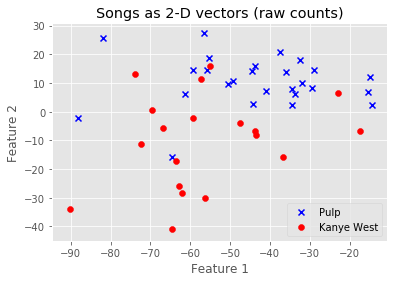

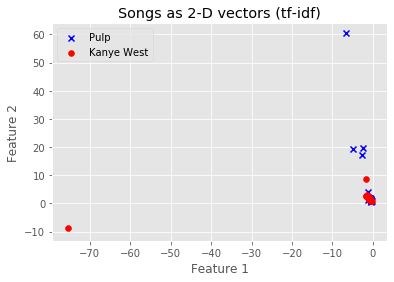

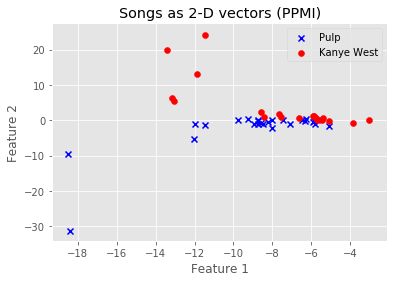

In [19]:
import matplotlib.pyplot as plt

def plot_songs(song_matrix, title):

    plt.style.use('ggplot')
    plt.title(title)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")

    pulp = plt.scatter(song_matrix[0,:26], song_matrix[1,:26], marker="x", color="blue")
    kanye = plt.scatter(song_matrix[0,26:], song_matrix[1,26:], marker="o", color="red")
    
    plt.legend((pulp, kanye),('Pulp', 'Kanye West'))
    
    plt.show()
    
plot_songs(td_matrix_dense, "Songs as 2-D vectors (raw counts)")
plot_songs(tf_idf_matrix_dense, "Songs as 2-D vectors (tf-idf)")
plot_songs(ppmi_matrix_dense, "Songs as 2-D vectors (PPMI)")

## TASK 5
### Transform new songs


Now we have new songs coming into our system and we would like to know if they are by Pulp or by Kanye.

The first thing to do is to adjust our query documents to the way we represent the songs in our systems.

1. Raw counts: pre-process, collect counts
2. Tf-idf: pre-process, collect counts, weight
3. PPMI: pre-process, collect counts, weight
4. LSI of Raw counts: pre-process, collect counts, LSI transform
5. LSI of Tf-idf: pre-process, collect counts, weight, LSI transform
6. LSI of PPMI: pre-process, collect counts, weight, LSI transform

### Step 1.1: Read and Normalize songs

In [20]:
import glob
# collect the paths to albums and songs
# the order of the albums are: my_beautiful_dark_twisted_fantasy, this_is_hardcore
test_songs = glob.glob('/coursedata/songs_test/*/*')

normalized_query_songs = [tokenize_and_normalize(song) for song in test_songs]

## 5.1
### Step 1.2: Get counts

Well, this part is a bit tricky. There might be new, unseen words in our queries, and if we want to count them, we just won't be able to compare our new documents to our old documents (different words = different dimensions = different vector spaces). To avoid this problem, we will need to only count the things we've seen in the training corpus. Luckily, we've collected the sorted vocabulary!

Modify the create_term_doc_matrix() function, so that it takes a query document, an old vocabulary, and counts only the words that are in our train vocabulary.

In [21]:
def create_term_doc_matrix_queries(queries, vocab):
    """
    this function takes in a list of query songs and the sorted vocabulary of our collection, 
    and returns a term-document matrix as a numpy array.
    the rows are word stems, the columns are songs. 
    the rows should be sorted according to the vocabulary.
    INPUT:
    queries - a list of songs represented as a list of stems (a list of lists)
    vocab - an alphabetically sorted list of all the words used in all songs of the collection (the rows of our matrix).
    OUTPUT:
    matrix - a matrix where columns are songs and rows are stems,
        the cells of the matrix contain stem frequencies in a song,
        the words for rows are sorted alphabetically.
    """
    
    # YOUR CODE HERE
    matrix = []

    for stem in vocab:
        i = 0
        count = 0
        tmp = np.zeros(len(queries))
        for song in queries:
            for word in song:
                if word == stem:
                    tmp[i] += 1
                else:
                    continue
            i += 1
        matrix.append(tmp)
            
    matrix = np.array(matrix)
    #print(matrix)
    
    return matrix    

In [22]:
from numpy.testing import assert_array_equal
from nose.tools import assert_equal

sorted_dummy_vocab = ['!', ',', 'bla', 'la', 'oh', 'tadada', 'tarara', 'uuuuuh', 'woo']
new_dummy_songs = [['la','oh',',','pada',"uuuuuh"],
                   ['toot','toot']]

# CHECKING THE GENERAL PROPERTIES OF THE OUTPUT
# check the shape of the matrix
assert_equal(create_term_doc_matrix_queries(new_dummy_songs, sorted_dummy_vocab).shape, (9, 2))

# CHECKING THAT THE FUNCTION IS WORKING AS IT SHOULD
# check that the matrix has the right values in the right places
correct_td_new_dummy_matrix = np.array([[0., 3.],
                                    [1., 0.],
                                    [0., 2.],
                                    [3., 3.],
                                    [1., 1.],
                                    [0., 1.],
                                    [0., 1.],
                                    [1., 0.],
                                    [1., 0.]])

assert_array_equal(create_term_doc_matrix_queries(new_dummy_songs, sorted_dummy_vocab),np.array([[0., 0.],
                                                                                        [1., 0.],
                                                                                        [0., 0.],
                                                                                        [1., 0.],
                                                                                        [1., 0.],
                                                                                        [0., 0.],
                                                                                        [0., 0.],
                                                                                        [1., 0.],
                                                                                        [0., 0.]]))



### Step 2: Get tf-idf counts
### Step 3: Get PPMI counts
### Steps 4-6 transform matrices with LSI

In [23]:
# step 1.2
td_queries = create_term_doc_matrix_queries(normalized_query_songs, sorted_vocabulary)
# step 2
tf_idf_queries = td_queries*idf_vector
# step 3
ppmi_queries = ppmi(td_matrix, td_queries)

# steps 4-6
td_queries_dense = lsi(td_matrix,2).T.dot(td_queries)
tf_idf_queries_dense = lsi(tf_idf_matrix,2).T.dot(tf_idf_queries)
ppmi_queries_dense= lsi(ppmi_matrix,2).T.dot(ppmi_queries)

nb_doc=  19205.0
cd:  [473. 288. 493. 309. 439. 338. 191. 251. 482. 588. 665. 303. 457. 456.
 478. 171. 612. 441. 305. 695. 406. 317. 378. 321. 266. 442. 622. 188.
 486. 206. 295. 478. 568. 454. 443. 539. 421. 229. 686. 618. 465. 344.
 580. 455. 563.]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log2


## TASK 6
### Cosine similarity
Now that we have the documents represented as vectors, we need some measure to be able to compare them to each other. You're going to implement **Cosine similarity**.


**Cosine similarity**:

$cos(x,y)=\frac{\sum_{i=1}^{n}x_iy_i}{\sqrt{\sum_{i=1}^{n}x_i^2}\sqrt{\sum_{i=1}^{n}y_i^2}}$

## 6.1
Write the function that implement the cosine similarity measure.

In [24]:
import math
import numbers
def cosine(doc1,doc2):
    """
    this function takes in two document vectors and computes cosine similarity between them
        when any of the vectors contains only zeros, their similarity is unknown (no common words)
        your function should output -inf
    
    INPUT:
    doc1 - the first document vector 
    doc2 - the second document vector 
    OUTPUT:
    score - cosine similarity
    """
    
    # YOUR CODE HERE
    #print("doc1 = ", doc1)
    #print("doc2 = ", doc2)
    
    if np.count_nonzero(doc1) == 0:
        return float("-inf")
    if np.count_nonzero(doc2) == 0:
        return float("-inf")
    #print("doc1*doc2=", doc1*doc2)
    numerator = sum(doc1*doc2)
   
    #print("numerator = ", numerator)
    ddoc1 = np.sum(doc1**2)
    ddoc2 = np.sum(doc2**2)
    
    #print("====== doc1 ======")
    #print("ddoc1.shape = ", np.shape(ddoc1), " and ddoc1 = ", ddoc1)
    ddoc1 = math.sqrt(ddoc1)
    #print("ddoc1.shape = ", np.shape(ddoc1), " and ddoc1 = ", ddoc1)
    #print("====== doc2 ======")
    #print("ddoc2.shape = ", np.shape(ddoc2), " and ddoc2 = ", ddoc2)
    ddoc2 = math.sqrt(ddoc2)
    #print("ddoc2.shape = ", np.shape(ddoc2), " and ddoc2 = ", ddoc2)
    #print("==================")
    score = []
    score.append((numerator / (ddoc1 * ddoc2)))
    #print("len(score): ", len(score), " & score: ", score)
    #if len(score) > 1:
    #    score = sum(score)
    #print("len(score): ", len(score), " & score: ", score)
    return score

In [25]:
from numpy.testing import assert_almost_equal, assert_array_equal, assert_allclose
from nose.tools import assert_equal

dummy_x = np.arange(3)
dummy_y = np.arange(3,6)

assert_almost_equal(cosine(dummy_x,dummy_y),0.8854377448471461, 3)


## TASK 7
### IR quality

All-in-all we have 6 systems now: raw counts, tf-idf, PPMI, and LSI applied to the first three systems.

Let's see which of them works best. We're are going to use as queries previously unseen songs. For Pulp it's going to be songs from *This is Hardcode* and for Kanye it's going to be songs from  *My Beautiful Dark Twisted Fantasy*

For every song in our query songs we're going to look at 7 closest songs from our collection and see how many of those are from the same artist.

## 7.1 
### Find N closest documents to a quesry song
Write a function that compares new songs to the songs in our collection. For each song, it should give out an index of top N most similar songs from our collection.

In [30]:
def closest_n_documents(matrix_collection, matrix_queries, n):
    """
    this function takes in original document collection, new document collection,
    computes cosine similarity between documents in old and new collection, 
    and outputs the list of n-closest documents to each new song.
    INPUT:
    matrix_collection - a term-document matrix of collection songs 
    matrix_queries - a term-document matrix of query songs 
    n - number of best documents
    OUTPUT:
    closest_docs - a list of lists of length matrix_queries.shape[1]
        each element is a list of n idices of documents in matrix_collection that were closest to the query
    """
    # YOUR CODE HERE
    print("matrix_collection(shape): ", np.shape(matrix_collection)," & val= ") 
    print(matrix_collection)
    print("=================")
    print("matrix_queries(shape): ", np.shape(matrix_queries), " & val= ") 
    print(matrix_queries)
    best_cosines = np.zeros((np.shape(matrix_queries)[1], n))
    #best_cosines = []
    
    print("matrix_queries(shape): ", np.shape(matrix_queries), "& val: ", matrix_queries )
    
    #for i , song in enumerate(best_cosines):
    #    for j , index in enumerate(best_cosines):
    #        for song in matrix_queries.T:
    #            tmp = []
    #            for clc in matrix_collection.T:
    #                tmp.append(cosine(clc, song))
    #        best_cosines[i][j] = [sorted(tmp)[-n:]]
            
    best_cosines = []
    for doc1 in matrix_queries.T:
        res = np.array([cosine(doc1, doc2) for doc2 in matrix_collection.T])
        best_cosines.append(list(res.argsort()[-n:][::-1]))
    
    #for term in matrix_queries:
    #    for song in matrix_queries:
    #        tmp = []
    #        for clc in matrix_collection:
    #            tmp.append(cosine(clc, song))
    #    best_cosines.append([tmp])

    print("===========best_cosines==========")
    print("shape: ", np.shape(best_cosines))
    #print(best_cosines)
    print("=================================")
    return best_cosines

In [31]:
from numpy.testing import assert_almost_equal, assert_array_equal, assert_allclose
from nose.tools import assert_equal


dummy_collection = np.arange(15).reshape((5,3))
dummy_query = np.arange(5).reshape((5,1))

# CHECKING THE GENERAL PROPERTIES OF THE OUTPUT
# check the length of the list
assert_equal(len(closest_n_documents(dummy_collection, dummy_query, 1)), 1)
# check the len of the first element
assert_equal(len(closest_n_documents(dummy_collection, dummy_query, 1)[0]), 1)

# CHECKING THAT THE FUNCTION IS WORKING AS IT SHOULD
closest_vector_id = closest_n_documents(dummy_collection, dummy_query, 1)[0][0]
assert_equal(closest_vector_id, 0)

matrix_collection(shape):  (5, 3)  & val= 
[[ 0  1  2]
 [ 3  4  5]
 [ 6  7  8]
 [ 9 10 11]
 [12 13 14]]
matrix_queries(shape):  (5, 1)  & val= 
[[0]
 [1]
 [2]
 [3]
 [4]]
matrix_queries(shape):  (5, 1) & val:  [[0]
 [1]
 [2]
 [3]
 [4]]
===========best_cosines==========
shape:  (1, 1, 1)
matrix_collection(shape):  (5, 3)  & val= 
[[ 0  1  2]
 [ 3  4  5]
 [ 6  7  8]
 [ 9 10 11]
 [12 13 14]]
matrix_queries(shape):  (5, 1)  & val= 
[[0]
 [1]
 [2]
 [3]
 [4]]
matrix_queries(shape):  (5, 1) & val:  [[0]
 [1]
 [2]
 [3]
 [4]]
===========best_cosines==========
shape:  (1, 1, 1)
matrix_collection(shape):  (5, 3)  & val= 
[[ 0  1  2]
 [ 3  4  5]
 [ 6  7  8]
 [ 9 10 11]
 [12 13 14]]
matrix_queries(shape):  (5, 1)  & val= 
[[0]
 [1]
 [2]
 [3]
 [4]]
matrix_queries(shape):  (5, 1) & val:  [[0]
 [1]
 [2]
 [3]
 [4]]
===========best_cosines==========
shape:  (1, 1, 1)


### Collect performance statistics for every query song by every model
The code below looks how many songs out of the closest 7 were by the same artist.

In [32]:
models = [td_matrix, tf_idf_matrix, ppmi_matrix, 
          td_matrix_dense, tf_idf_matrix_dense, ppmi_matrix_dense]
queries = [td_queries, tf_idf_queries, ppmi_queries,
           td_queries_dense, tf_idf_queries_dense, ppmi_queries_dense]

pulp_ids_collection = list(range(25))
pulp_ids_query = list(range(12, td_queries.shape[1]))
kanye_ids_collection = list(range(25, td_matrix.shape[1]))
kanye_ids_query = list(range(12))

relevance_pulp = []
relevance_kanye = []
for i in range(len(models)):
    model_relevance_pulp = []
    model_relevance_kanye = []
    
    # collect results 
    model_results = closest_n_documents(models[i], queries[i], 7)

    #check pulp
    for song_id in pulp_ids_query:
        model_relevance_pulp.append(sum([1 for song in model_results[song_id] if (song in pulp_ids_collection)]))
    relevance_pulp.append(model_relevance_pulp)
    # check kanye
    for song_id in kanye_ids_query:
        model_relevance_kanye.append(sum([1 for song in model_results[song_id] if (song in kanye_ids_collection)]))
    relevance_kanye.append(model_relevance_kanye)       

matrix_collection(shape):  (1594, 45)  & val= 
[[ 0.  0.  0. ...  0.  0.  9.]
 [ 1.  0.  0. ... 15. 12. 25.]
 [ 0.  0.  0. ...  6.  0.  1.]
 ...
 [ 0.  0.  0. ...  1.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]]
matrix_queries(shape):  (1594, 28)  & val= 
[[ 0. 20.  1. ...  0.  0.  0.]
 [ 0.  4.  1. ...  0.  0.  0.]
 [ 1.  9.  0. ...  1.  1.  0.]
 ...
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0. 19. ...  0.  0.  0.]]
matrix_queries(shape):  (1594, 28) & val:  [[ 0. 20.  1. ...  0.  0.  0.]
 [ 0.  4.  1. ...  0.  0.  0.]
 [ 1.  9.  0. ...  1.  1.  0.]
 ...
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0. 19. ...  0.  0.  0.]]
===========best_cosines==========
shape:  (28, 7, 1)
matrix_collection(shape):  (1594, 45)  & val= 
[[ 0.          0.          0.         ...  0.          0.
   5.50637846]
 [ 0.57403127  0.          0.         ...  8.61046902  6.88837521
  14.35078169]
 [ 0.          0.          0.       

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in multiply


===========best_cosines==========
shape:  (28, 7, 1)
matrix_collection(shape):  (2, 45)  & val= 
[[-44.54519571 -34.4122765  -55.39650439 -31.98026103 -33.79570153
  -34.48679385 -14.387621   -14.92983798 -50.42294282 -61.20765459
  -56.53036894 -44.18990079 -49.33790554 -55.89837132 -37.47490081
  -15.44595354 -81.86502067 -59.36374696 -36.01137623 -88.1561378
  -64.58317893 -29.02970444 -40.96906375 -32.52994103 -29.34219587
  -43.75197822 -66.82227388 -17.37277957 -69.5774115  -22.96646615
  -36.75078377 -54.98578662 -73.77562111 -63.55056028 -64.47852408
  -57.39549573 -56.2987003  -43.44840706 -90.08101197 -72.39449503
  -62.74170879 -43.6157182  -59.29420233 -47.52017982 -61.98644663]
 [ 14.04295061   7.86647494  18.78328424  10.02398273   6.18302797
    2.3437646    2.4607265   12.02325964   9.6997246    6.04773828
   27.34107091   2.79914443  10.6560938   14.68731935  20.79541569
    6.87701033  25.57195538  14.38087352  13.85605419  -2.0378578
  -15.67642582  14.5410813    7.2

===========best_cosines==========
shape:  (28, 7, 1)


## 7.2 
### Compare models
Now we've collected results for each model and for each song in our test corpus let's evaluate our models. We will be looking at five measures: 

1. Precision = $\frac{tp}{tp + fp}$ (how many right answers from all answers)
2. Recall = $\frac{tp}{tp + fn}$ (how many right answers from all possible right answers)
3. Accuracy = $\frac{tp+tn}{N}$ (how many right artists were chosen and how many wrong artist we NOT chosen, out of all songs in collection)
4. Error = $\frac{fp+fn}{N}$ (how many right artists were NOT chosen, and how many wrong artist we chosen, out of all songs in collection)
5. F-measure $\frac{1}{\alpha\frac{1}{P}+(1-\alpha)\frac{1}{R}}$
$P$ stands for precision and $R$ for recall, while $\alpha$ controls the weighting between them. If we choose $\alpha = 0.5$,
$F = \frac{2PR}{P+R}$


Here: $tp$ = True Positives, $fp$ = False Positives, $fn$ = False Negatives, $tn$ = True Negatives, $N$ = the size of the collection.


In the cell below, calculate the mean measure for every model. That is: count the results, sum them and divide by the number of songs in the training set. For the F-measure choose $\alpha = 0.5$.

In [33]:
# the order of models is: raw counts, tf-idf, PPMI, LSI raw counts, LSI tf-idf, LSI PPMI

# type in the answer as a list of 6 values
average_precision = None
# type in the answer as a list of 6 values
average_recall = None
# type in the answer as a list of 6 values
average_accuracy = None
# type in the answer as a list of 6 values
average_error = None
# type in the answer as a list of 6 values
average_f_measure = None
# type in the answer as a list of 6 values

#Remember to remove the raise NotImplementedError line:
# YOUR CODE HERE
raise NotImplementedError()

model_names = ["raw counts", "tf-idf", "PPMI", "LSI raw counts", "LSI tf-idf", "LSI PPMI"]
for i, model_name in enumerate(model_names):
    print(model_name)
    print("average previcision:", average_precision[i])
    print("average_accuracy:", average_accuracy[i])
    print("average_recall:", average_recall[i])
    print("average_error:", average_error[i])
    print("average_f_measure:", average_f_measure[i])
    print("============")

NotImplementedError: 

In [ ]:
### This cell contains hidden tests for the correct answers.
from numpy.testing import assert_almost_equal, assert_array_equal, assert_allclose
from nose.tools import assert_equal


## 7.3
### Choose the best model
Answer briefly in the cell below: 
* What model performed best? 
* What do you think is the reason?


YOUR ANSWER HERE

In [ ]:
# I had a problem with SVD, I mean if I were to implement the function from scratch, as I lack knowledge in eigenvalues eigenvectors

In [ ]:
# The Task 7.1 is so hard I can't even understand How do I reformulate what's written ( List of lists of length ???)